In [1]:
!pip install scikit-learn pandas langid

1. Can we accurately predict the language of a user prompt based only on its text?

In [1]:
# Load dataset & extract user prompt

In [2]:
import pandas as pd

# Load parquet file
df = pd.read_parquet("wildchat_train.parquet")

# Extract first user message
def first_user_prompt(conversation):
    for turn in conversation:
        if turn["role"] == "user":
            return turn["content"]
    return ""

df["user_text"] = df["conversation"].apply(first_user_prompt)
df = df[df["user_text"].str.len() > 0]

print("Total rows after cleaning:", len(df))

Total rows after cleaning: 831265


In [2]:
# Sample SMALL subset

In [3]:
df_small = df.sample(n=10000, random_state=42).copy()

In [3]:
# Creating language labels

In [4]:
import langid

# Restrict to common languages (big speed boost)
langid.set_languages(['en', 'es', 'fr', 'de', 'pt', 'it'])

# Use only first 200 chars (enough for language ID)
df_small["language"] = df_small["user_text"].astype(str).str.slice(0, 200).apply(
    lambda x: langid.classify(x)[0]
)

print(df_small["language"].value_counts())

language
en    8052
pt     677
fr     550
es     313
de     310
it      98
Name: count, dtype: int64


In [4]:
# Train / Test split

In [5]:
from sklearn.model_selection import train_test_split

X = df_small["user_text"].astype(str).str.slice(0, 200)
y = df_small["language"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [5]:
# Using Linear SVM (best speed + accuracy)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(2, 4),      # SAFE range
        max_features=100000,     # HARD LIMIT
        min_df=5
    )),
    ("clf", LinearSVC())
])

print("Training model...")
model.fit(X_train, y_train)
print("Training completed!")

Training model...
Training completed!


In [6]:
# Evaluate model

In [7]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.913

Classification Report:
               precision    recall  f1-score   support

          de       0.92      0.73      0.81        62
          en       0.92      0.98      0.95      1610
          es       0.92      0.70      0.79        63
          fr       0.87      0.55      0.68       110
          it       1.00      0.50      0.67        20
          pt       0.76      0.60      0.67       135

    accuracy                           0.91      2000
   macro avg       0.90      0.68      0.76      2000
weighted avg       0.91      0.91      0.91      2000



In [7]:
# Confusion Matrix

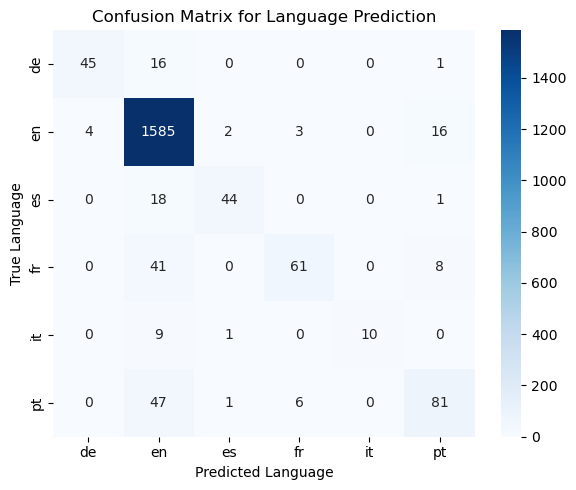

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels,
            yticklabels=labels,
            cmap="Blues")
plt.xlabel("Predicted Language")
plt.ylabel("True Language")
plt.title("Confusion Matrix for Language Prediction")
plt.tight_layout()
plt.show()

2. Can we classify whether a conversation is short or long based on simple features from the first user message?

In [10]:
!pip install pandas scikit-learn

In [8]:
# Load data + extract first user message + conversation length

In [11]:
import pandas as pd

df = pd.read_parquet("wildchat_train.parquet")

def first_user_prompt(conversation):
    for turn in conversation:
        if turn.get("role") == "user":
            return turn.get("content", "")
    return ""

def num_turns(conversation):
    return len(conversation)

df["user_text"] = df["conversation"].apply(first_user_prompt)
df["turn_count"] = df["conversation"].apply(num_turns)

# keep non-empty user prompts
df = df[df["user_text"].str.len() > 0].copy()

print("Rows after cleaning:", len(df))
print(df[["user_text","turn_count"]].head())

Rows after cleaning: 831265
                                           user_text  turn_count
0  Hey there! Are you familiar with reality shift...           2
1  Crea una imagen de una mujer corriente por la ...           4
2  Old age PT hx of DM, HTN, dyslipidemia His ECG...           2
3  calcula la mediana de followers: # Calcular la...           2
4  Hey there! Are you familiar with reality shift...           2


In [9]:
# Sample for speed

In [12]:
df_small = df.sample(n=30000, random_state=42).copy()

In [10]:
# Create labels: Short vs Long

In [13]:
df_small["label"] = (df_small["turn_count"] >= 3).astype(int)
# 0 = short, 1 = long

print(df_small["label"].value_counts())

label
0    18270
1    11730
Name: count, dtype: int64


In [11]:
# Build simple features from first user text

In [14]:
import re

def word_count(text):
    return len(text.split())

def char_count(text):
    return len(text)

def num_questions(text):
    return text.count("?")

def num_digits(text):
    return sum(c.isdigit() for c in text)

df_small["word_count"] = df_small["user_text"].astype(str).apply(word_count)
df_small["char_count"] = df_small["user_text"].astype(str).apply(char_count)
df_small["num_questions"] = df_small["user_text"].astype(str).apply(num_questions)
df_small["num_digits"] = df_small["user_text"].astype(str).apply(num_digits)

feature_cols = ["word_count", "char_count", "num_questions", "num_digits"]
X = df_small[feature_cols]
y = df_small["label"]

In [12]:
# Train / test split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [13]:
# Train model

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Training completed!")

Training completed!


In [14]:
# Evaluate model

In [17]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Short", "Long"]))

Accuracy: 0.609

Classification Report:
               precision    recall  f1-score   support

       Short       0.61      1.00      0.76      3654
        Long       0.50      0.00      0.00      2346

    accuracy                           0.61      6000
   macro avg       0.55      0.50      0.38      6000
weighted avg       0.57      0.61      0.46      6000



In [15]:
# Confusion matrix plot

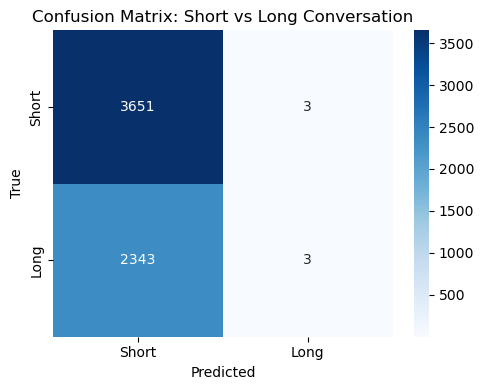

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Short","Long"],
            yticklabels=["Short","Long"],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Short vs Long Conversation")
plt.tight_layout()
plt.show()